In [2]:
# standard libraries, not all are needed 
import numpy as np                      # all of math 
from scipy import stats                 # statistical methods
import pandas as pd                     # for Dataframes
import statsmodels.api as sm            # contains GLM
import statsmodels.formula.api as smf   # same glm with patsy 
import patsy                            # handles formula strings
from matplotlib import pyplot as plt    # plotting methods
# The following keeps graphics inline=persistent within this notebook after saving/closing
%matplotlib inline

# GLM

# Aufgabe 1: Ohnmacht

#### Fitten Sie das Beispiel der Jet-Piloten mit Blackout
mit einem Binomial-Modell mit Logit Link-Funktion

#### T.F.:

In [3]:
# read the data
data = pd.read_csv('gforces.txt', sep='\t',)

# prepare x; add a column with 1's
data_x = data[['Age']]
data_x = sm.add_constant(data_x)


# prepare y
data_y = data[['Signs']]
data_y

# fit the model
model_jet = sm.GLM(endog=data_y, exog=data_x, family=sm.families.Binomial(link=sm.families.links.logit))
jet_results = model_jet.fit()
# show the results
print(jet_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Signs   No. Observations:                    8
Model:                            GLM   Df Residuals:                        6
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -4.2173
Date:                Wed, 09 May 2018   Deviance:                       8.4345
Time:                        11:47:37   Pearson chi2:                     7.42
No. Iterations:                     4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9209      2.647     -1.104      0.270      -8.108       2.266
Age            0.1057      0.080      1.315      0.1

#### Was bedeuten die Parameter?
- die der Fit zurückgibt?
- Wie lautet die Logit-Funktion?

### Antwort:
- "const"
- "Age"
- Logit-Funktion:

#### Reproduzieren Sie damit die Graphik
mit Beschriftung für die Daten und das Logit-Modell
- x-Achse: Alter
- y-Achse: Wahrscheinlichkeit für Blackout

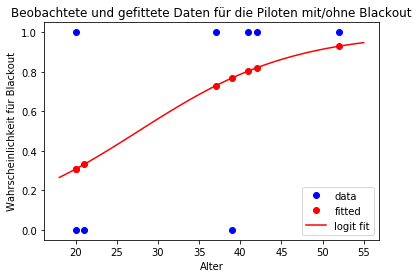

In [4]:
plt.plot(data[['Age']], data[['Signs']], 'bo', label='data')
plt.plot(data[['Age']], jet_results.fittedvalues, 'ro', label='fitted')

dgrid = np.linspace(18, 55)
xgrid = sm.add_constant(dgrid)
plt.plot(dgrid, jet_results.predict(xgrid), 'r-', label='logit fit')

plt.title('Beobachtete und gefittete Daten für die Piloten mit/ohne Blackout')
plt.xlabel('Alter')
plt.ylabel('Wahrscheinlichkeit für Blackout')
plt.legend(loc='lower right');

#### Wie groß ist die Wahrscheinlichkeit
- für eine 45-Jährige, einen Blackout zu erleiden?
- Wie groß ist sein Chancenverhältnis (odds-ratio)
- Wie groß ist sein logarithmiertes Chancenverhältnis (log-odds-ratio)

In [5]:
# get the probability for a 45 to black out by using the model:
p = jet_results.predict([[1, 45]])
p = p[0]
print('Probability:', p)

# calculate the odds-ratio for a 45 year old:
print('Odds-ratio:', p / (1-p))

# calculate the log-odds-ratio
print('log-odds-ratio:', np.log(p / (1-p)))
# or:
print('LOR calculated with the logit function:', -2.9209+0.1057*45)

Probability: 0.8623883612488173
Odds-ratio: 6.266827203534089
log-odds-ratio: 1.835270198424896
LOR calculated with the logit function: 1.8356


#### Bonus: Wie groß ist die Deviance 
- für das Modell (aus der Theorie)?
    - Geben Sie die Formel an, es genügt eine Python-Formel (mit Kommentar), berechnen Sie sie damit numerisch
- wie groß die aus dem `fit()` erhaltene Deviance?
- und wie hängen diese zusammen?

Obacht, bei Fehlern bitte nachdenken.

- Definition Deviance?
- Formel gemäß Exponentialfamilie?
- Maximales Modell? 
    - Grenzwerte(!)
- Statistik?
- Berechnung gemäß Modell
- Berechnung gemäß GLM-Fit
    - residuale Deviances?  

(5+1 Punkte)

---

# Aufgabe 2: Säugetiergehirne

#### Wie schwer sollte das Gehirn eines Erdhörnchens*Groundsquirrel* sein
- wenn es dem Modell "ein Säugetier" entspricht
- wenn es dem Modell "Affe" entspricht
- wenn es dem Modell "Säugetier ohne Affen" entspricht
- wenn es dem gewichteten ($n_{Affe}$ und $n_{\overline{Affe}}$) Mittel ein Mischwesen "Affe - kein Affe" wäre

#### F.W.:

In [24]:
'''import the dataset from csv file (tab-separated) into a Pandas dataframe object:'''
animals = pd.read_csv('animals.txt', sep='\t')  # tab-separated

'''rescale weight because of spread: create new variable from linear data'''
animals['log_BodyWt'] = np.log10(animals['BodyWt'])             # new variable, converted from original data
animals['log_BrainWt'] = np.log10(animals['BrainWt'])           # new variable, converted from original data
animalsdata = animals[['log_BodyWt', 'log_BrainWt', 'Species']] # focus on list of relevant data
animalsdata = animalsdata.dropna(axis=0)                        # drop lines with invalid data

'''fit linear Gaussian (default) model with Patsy formula'''
wfit = smf.glm(formula='log_BrainWt ~ log_BodyWt', data=animalsdata).fit()

# get data
x = np.asarray(animalsdata['log_BodyWt'])            # extract independent variable
y = np.asarray(animalsdata['log_BrainWt'])           # extract dependent variable
y_hat = np.asarray(wfit.fittedvalues)                # estimated linear result
x_bar = x.mean()

'''distinguish monkeys from other mammals'''
animalsdata['IsMonkey']='no'                                             # create new variable in dataframe
pnames = ['Man', 'Baboon', 'Chimpanzee', 'Gorilla', 'Owlmonkey', 
          'Patasmonkey', 'Rhesusmonkey', 'Galago' ]                      # list of old world monkeys
animalsdata.loc[animalsdata['Species'].isin(pnames), 'IsMonkey'] = 'yes' # locate and change

'''enhanced linear model: monkeys ------v  separated from other mammals'''
mfit = smf.glm(formula='log_BrainWt ~ IsMonkey + log_BodyWt', data=animalsdata).fit() 

'''add groundsquirrel to the ape family'''
animalsdata.loc[animalsdata['Species'].isin(['Groundsquirrel']), 'IsMonkey'] = 'yes' # locate and change

mfit2 = smf.glm(formula='log_BrainWt ~ IsMonkey + log_BodyWt', data=animalsdata).fit() 

print("The weight of a groundsquirrel in the 'Mammal-Model' is predicted as:", np.power(10,y_hat[26]))
print("The weight of a groundsquirrel in the 'Ape-Model' is predicted as:", np.power(10,np.asarray(mfit2.fittedvalues)[26]))
print("The weight of a groundsquirrel in the 'None-Ape-Model' is predicted as:", np.power(10,np.asarray(mfit.fittedvalues)[26]))


The weight of a groundsquirrel in the 'Mammal-Model' is predicted as: 1.509000285711569
The weight of a groundsquirrel in the 'Ape-Model' is predicted as: 4.3985627509081
The weight of a groundsquirrel in the 'None-Ape-Model' is predicted as: 1.3575027372967097


#### T.F.:

In [26]:
animalsdata = animals[['Species', 'BodyWt', 'BrainWt', 'log_BodyWt', 'log_BrainWt']].copy()

animalsdata['IsMonkey']='no'                                             # create new variable in dataframe
pnames = ['Man', 'Baboon', 'Chimpanzee', 'Gorilla', 'Owlmonkey', 
          'Patasmonkey', 'Rhesusmonkey', 'Galago' ]                      # list of old world monkeys
animalsdata.loc[animalsdata['Species'].isin(pnames), 'IsMonkey'] = 'yes' # locate and change

gs = animalsdata.loc[animalsdata['Species'] == 'Groundsquirrel']      # the row with the measured data for the squirrel
gs_log_weight = np.asarray(gs['log_BodyWt'])[0]

brainWt1 = np.power(10, 0.9271+0.7517 * gs_log_weight)
brainWt2 = np.power(10, 0.8670+0.5303 * 1 + 0.7374 * gs_log_weight)
brainWt3 = np.power(10, 0.8670+0.5303 * 0 + 0.7374 * gs_log_weight)

print('Measured weight of the squirrels brain:', np.asarray(gs['BrainWt'])[0])
print('Predicted value for model 1:', brainWt1)
print('Predicted value for model 2:', brainWt2)
print('Predicted value for model 3:', brainWt3)

n_M = len(animalsdata.loc[animalsdata['IsMonkey'] == 'yes'])   # number of animals that are monkeys
n_nM = len(animalsdata.loc[animalsdata['IsMonkey'] == 'no'])   # number of not-monkes

brainWt4 = (brainWt2 * n_M + brainWt3 * n_nM) / (n_M + n_nM)
print('Predicted value for model 4:', brainWt4)

Measured weight of the squirrels brain: 4.0
Predicted value for model 1: 1.5088580237041396
Predicted value for model 2: 4.60348339562958
Predicted value for model 3: 1.3576461144981522
Predicted value for model 4: 1.7764638281925302


#### Erklären Sie jeweils den Unterschied
... der obigen sowie dem gemessenen Gewicht in ein paar Sätzen. 

Was schließen Sie daraus?

gemessener Wert beträgt 4,0g.

Vorhersage Modell "Säugetier" ist zu gering

Vorhersage erweitertes Modell ist besser

Vorhersage erweitertes Modells nicht-Affe ist noch schlechter

Erdhörnchen ist ein recht großer Ausreißer, was die Körpergewicht-Gehirngewicht-Rate angeht.

#### Hinweis
Orientieren Sie sich an den Modellen aus der Vorlesung, berechnen Sie die Vorhersage mit den glm-Methoden aus dem Fit heraus, indem Sie eine passende (*exogene*) Variable (*predictor*) als `DataFrame` übergeben. Oder bequemer das *Formel*-Modell benutzen.

#### Bonus
Ist der Mensch im Datensatz auch für das separierte Modell und die Kategorie "Affe" ein Ausreißer ($\alpha=5\%$)?

In [27]:
# get the data for a human
human = animalsdata.loc[animalsdata['Species'] == 'Man']
human_log_BoW = np.asarray(human['log_BodyWt'])[0]
human_BrW = np.asarray(human['BrainWt'])[0]

# calculate the predicted brain weight for a human for the advanced model and isMonkey? = 1
pred_human_BrW = np.power(10, 0.8670+0.5303 * 1 + 0.7374 * human_log_BoW)
print('predicted brain weight:', pred_human_BrW)
print('measured brain weight:', human_BrW)
print('Ratio between measured and predicted:', human_BrW / pred_human_BrW)

predicted brain weight: 523.6120491888954
measured brain weight: 1320.0
Ratio between measured and predicted: 2.5209503907420663


Der Mensch im Datensatz ist definitiv ein Ausreißer. Gemessen wurden 1320g Gehirnmasse und vorhergesagt wurden nur 524g. Die Diskrepanz zwischen gemessenem und vorhergesagtem Wert beträgt über 250%.

#### Test(!)

(3+1 Punkte)

---

# Aufgabe 3: Vererbung der Augenfarbe

Galton (1889) hat die Vererbung von Augenfarbe (hell, dunkel, mittel/gemischt) anhand 78 Großfamilien mit mindestens 6 Kindern untersucht.
- Augenfarbe der Eltern P: (H: *hazel* (grün-braun), L: *light* oder D: *dark*)
- Augenfarbe der Großeltern G: (wie Eltern)
- Augenfarbe der Kinder (L: *light*)
In der Tabelle (csv-Datei) ist für jede Familie die Anzahl der Eltern/Großeltern je Augenfarbenmerkmal sowie die Anzahl der Kinder der Familie N und die der helläugigen darunter L angegeben.

#### Laden Sie den Datensatz
und erstellen Sie passende Kategorien
- für Eltern (wie viele Kategorien für die Kombinationmöglichkeiten?)
- und Großeltern (wie viele Kategorien für diese Kombinationsmöglichkeiten?)
- sowie für die abhängige Variable $y$ der hellen Augenfarbe unter den Geschwistern
    - Was wählen Sie als sinnvolle abhängige Variable y?
    - Welche Verteilung ist für diese Variable angemessen? 
- **Hinweis:** ein `'C(x)'` im Patsy-String kategorisiert eine ansonsten metrische Variable $x$
und fügen diese drei Größen Pi, Gi und y als neue Variablen dem Datensatz hinzu

#### L.G.:

In [9]:
# Laden des Datensatzes
galton = pd.read_csv('GaltonEyeColorHeredity.csv', sep=',')

In [10]:
color_percentage = galton['L']/galton['N'] 
galton['percentage']=color_percentage  

#### Fit P
Passen Sie ein Modell mit einer Logit-Link-Funktion an.
- Beachten Sie zuerst **nur** die Eltern-Daten als lineare unabhängige Variable

Den Achsenabschnitt dürfen Sie weglassen.

In [11]:
# Fit für PARENTS
fit_parents = smf.glm('percentage ~ C(PL) + C(PH) + C(PD)', galton, family=sm.families.Binomial()).fit()
print(fit_parents.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             percentage   No. Observations:                   78
Model:                            GLM   Df Residuals:                       72
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -36.398
Date:                Wed, 09 May 2018   Deviance:                       127.53
Time:                        11:49:32   Pearson chi2:                     16.6
No. Iterations:                     7                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5200      0.410      1.268      0.205      -0.284       1.324
C(PL)[T.1]     0.4728      0.659      0.717      0.4

#### Ausreißer
- Suchen Sie die Ausreißer und verwerfen die Daten der *deutlichen* Ausreißer.
- Passen Sie das obige Modell nochmals an

In [12]:
# Prediction für das fit_parents Model für Definition der Ausreißer
prediction_parents = fit_parents.predict (galton.iloc[:,0:3]);

variance = prediction_parents - galton['percentage']
#plt.plot(variance);

Indizes der Ausreißer:
Int64Index([17, 46], dtype='int64')
                 Generalized Linear Model Regression Results                  
Dep. Variable:             percentage   No. Observations:                   76
Model:                            GLM   Df Residuals:                       70
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -33.089
Date:                Wed, 09 May 2018   Deviance:                       127.79
Time:                        11:49:37   Pearson chi2:                     9.26
No. Iterations:                     7                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6380      0.434      1.469      0.142      -0.213      

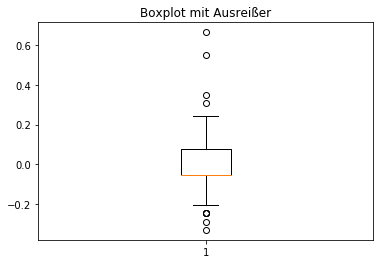

In [13]:
quantile_75 = variance.quantile(.75)
quantile_25 = variance.quantile(.25)
inter_quantile = quantile_75 - quantile_25

# Definition der deutlichen Ausreißer
# Hier habe ich das Doppelte der Definition der normalen Ausreißer genommen
obvious_outliers = variance[variance > quantile_75 + 3 * inter_quantile]
obvious_outliers = obvious_outliers.append(variance[variance < quantile_25 - 3 * inter_quantile])

print('Indizes der Ausreißer:')
print (obvious_outliers.index) 
plt.boxplot(variance);
plt.title('Boxplot mit Ausreißer');

# Anpassung des Models ohne Ausreißer
galton_02 = galton.drop(galton.index[obvious_outliers.index]) 
fit_parents_outliers = smf.glm('percentage ~ C(PL)+C(PH)+C(PD)', galton_02 ,family=sm.families.Binomial()).fit()
print(fit_parents_outliers.summary())

Nach meiner Definition habe ich nur 2 Ausreißer klassifiziert.

#### Ergebnis Eltern
- Fassen Sie die Vorhersage für alle Eltern-Kombinationen in einer 3x3 Tabelle zusammen
- Was erkennen Sie?
- Erklärung?

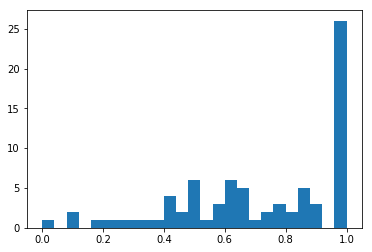

In [28]:
galtondaten = pd.read_csv("GaltonEyeColorHeredity.csv", sep = ",") 
anteilhelleraugen = (galtondaten["L"]/galtondaten["N"]) 
galtondaten["AnteilhellerAugen"] = anteilhelleraugen 
alleelternkombis = pd.DataFrame.drop_duplicates(galtondaten.iloc[:,0:3])
plt.hist(galtondaten["AnteilhellerAugen"], bins = 25); 

In [32]:
galtonfit = smf.glm(formula = "AnteilhellerAugen ~ C(PL) + C(PH) + C(PD)", data = galtondaten, family=sm.families.Binomial()).fit()
print(galtonfit.summary()) 

                 Generalized Linear Model Regression Results                  
Dep. Variable:      AnteilhellerAugen   No. Observations:                   78
Model:                            GLM   Df Residuals:                       72
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -36.398
Date:                Wed, 09 May 2018   Deviance:                       127.53
Time:                        12:09:16   Pearson chi2:                     16.6
No. Iterations:                     7                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5200      0.410      1.268      0.205      -0.284       1.324
C(PL)[T.1]     0.4728      0.659      0.717      0.4

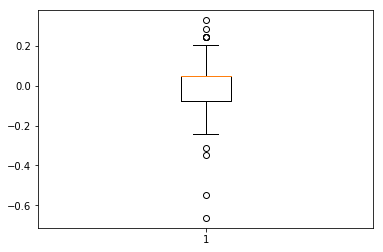

In [33]:
elternvorhersagen = galtonfit.predict(galtondaten.iloc[:, 0:3])
Abweichungen = anteilhelleraugen - elternvorhersagen 
plt.boxplot(Abweichungen) 
QA75 = Abweichungen.quantile(0.75) 
QA25 = Abweichungen.quantile(0.25) 
IQA = QA75 - QA25
Ausreißer = Abweichungen[Abweichungen > QA75 + 1.5 * IQA] 
Ausreißer = Ausreißer.append(Abweichungen[Abweichungen < QA25 - 1.5 * IQA])
ExtremeAusreißer = Abweichungen[Abweichungen > QA75 + 3 * IQA] 
ExtremeAusreißer = ExtremeAusreißer.append(Abweichungen[Abweichungen < QA25 - 3 * IQA])
galtondatenbereinigt = galtondaten.drop(galtondaten.index[ExtremeAusreißer.index]) 

In [34]:
galtonfit = smf.glm(formula = "AnteilhellerAugen ~ C(PL) + C(PH) + C(PD)", data = galtondatenbereinigt, family=sm.families.Binomial()).fit()
print(galtonfit.summary()) 

                 Generalized Linear Model Regression Results                  
Dep. Variable:      AnteilhellerAugen   No. Observations:                   76
Model:                            GLM   Df Residuals:                       70
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -33.089
Date:                Wed, 09 May 2018   Deviance:                       127.79
Time:                        12:10:54   Pearson chi2:                     9.26
No. Iterations:                     7                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6380      0.434      1.469      0.142      -0.213       1.489
C(PL)[T.1]     0.5257      0.673      0.781      0.4

In [35]:
ergebnisseeltern = np.asarray(fit_parents.predict(alleelternkombis)) 
eltern3x3 = pd.DataFrame([[ergebnisseeltern[0],ergebnisseeltern[3],ergebnisseeltern[4]],
             [ergebnisseeltern[3],ergebnisseeltern[1],ergebnisseeltern[5]],
             [ergebnisseeltern[4],ergebnisseeltern[5],ergebnisseeltern[2]]], columns = ["PL", "PH", "PD"], index = ["PL", "PH", "PD"])
eltern3x3 

,PL,PH,PD
PL,0.948905,0.754666,0.546658
PH,0.754666,0.598214,0.461386
PD,0.546658,0.461386,0.242544


#### J.M.:

Wenn beide Elternteile helläugig sind

Wenn beide Elternteile dunkeläugig sind

Diese zwei Einflüsse sind die einzigen signifikanten.

Da helle Augen rezessiv vererbt werden

#### Fit G
Fügen Sie nun zum Modell die zusätzliche kategorialen Variablen der Großeltern hinzu, auch dieses ohne Achsenabschnittsparameter.
- Denken Sie an die Möglichkeit  `'C(x)'` im Patsy-String
- Passen Sie das Modell an
- Erklären Sie augenscheinliche Unterschiede im `summary()`-Ergebnis zum vorigen nur-Eltern-Modell
    - [Erklären heißt erkennen, bennen, Ursache vermuten und begründen]

In [36]:
fit_par_gran = smf.glm('percentage ~ C(PL)+C(PH)+C(PD)+C(GL)+C(GH)+C(GD)', galton_02, family=sm.families.Binomial()).fit()

params_all = fit_par_gran.params
print (fit_parents_outliers.summary())
print (fit_par_gran.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             percentage   No. Observations:                   76
Model:                            GLM   Df Residuals:                       70
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -33.089
Date:                Wed, 09 May 2018   Deviance:                       127.79
Time:                        12:11:47   Pearson chi2:                     9.26
No. Iterations:                     7                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6380      0.434      1.469      0.142      -0.213       1.489
C(PL)[T.1]     0.5257      0.673      0.781      0.4

#### Erkennen Sie ein Muster für die Vererbung durch Großeltern?
- Plotten Sie hierzu die Originaldaten, die vom Modell P und die vom Modell P+G vorhergesagten Werte (der Einfachheit halber in einem Scatter hintereinanderweg)
    - **Hinweis** ohne Angabe eines x-Wertes für den `plt.plot()`-Befehl wird bei DataFrames `x` der interne Index genommen; wollen Sie das vermeiden, wandeln Sie die Daten in ein numpy-nd-array `np.asarray(x)` um
    - bei Vektoren (Listen, numpy-nd-arrays) wird automatisch ein neuer Index von 0 ab generiert

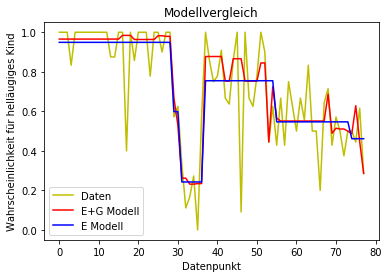

In [37]:
# Predictions der Datensätz E und E+P
prediction_parents = fit_parents.predict (galton.iloc[:,0:3]);
prediction_grannies = fit_par_gran.predict (galton.iloc[:,0:6]);

# Plot
plt.plot(galton['percentage'], 'y-', label = 'Daten')
plt.plot(prediction_grannies, 'r-', label = 'E+G Modell')
plt.plot(prediction_parents, 'b-', label = 'E Modell')
plt.xlabel('Datenpunkt')
plt.ylabel('Wahrscheinlichkeit für helläugiges Kind')
plt.title('Modellvergleich');
plt.legend(loc='lower left');

Wie man in dem Plot oben erkennt, Erlauben die Daten der Eltern und Großeltern eine bessere Vorhersage der Wahrscheinlichkeit ein Kind mit hellen Augen zu bekommen, als nur das Eltern Modell alleine.

#### Bonus 1
- Versuchen Sie dieses Ergebnis (Einfluß Großeltern) biologisch zu erklären.

### ANTWORT
Die Prädiktion wird durch das Eltern+Großeltern-Modell genauer. Die biologische Erklärung hierfür könnte sein, dass Augenfarben auch rezessiv vererbt werden können. Somit können auch Kinder von helläugigen Eltern braune Augen bekommen.

#### Bonus 2
- Können Sie manche Ausreißer erklären?

* Vater(?)
* Zahlendreher
* Rekombination
* Spontanmution

(6+1+1 Punkte)

----

Teilnehmende: 15
Ergebnis im Mittel=8.20, mit Standardabweichung=4.81


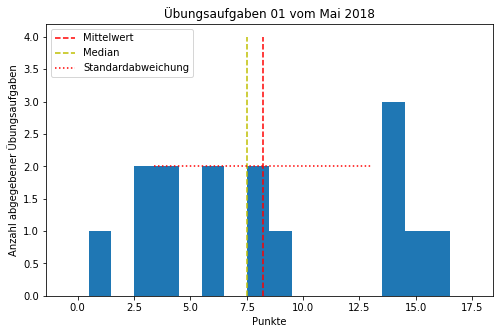

In [19]:
'''Ergebnisse Übungsaufgaben'''